## 0. Import necessary modules

In [1]:
# Add path to auxiliary custom libraries
import sys
sys.path.insert(0, './functions')

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from f_data_analysis import df_custom_info # Custom function
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from f_viz import plot_corr_heatmap # Custom function

In [3]:
# Extend number of Pandas df columns to display
pd.set_option('display.max_columns', 60)

In [4]:
%matplotlib inline

## 1. Load data

In [5]:
# Local paths to data
data_PATH = './data/'
proc_data_PATH = './processed_data/'

In [6]:
xlsx = pd.ExcelFile(data_PATH + 'Database.xlsx')
xlsx.sheet_names

['Glossary', 'DB_20000', 'DB_10000']

In [7]:
# "Observations" column is a simple numeric index which contains no relevant information (we drop it right away)
db_20k = pd.read_excel(xlsx, 'DB_20000').drop('Obs',axis=1)
db_10k = pd.read_excel(xlsx, 'DB_10000').drop('Obs',axis=1)

## 2. Preliminary overview of the two datasets

In [8]:
db_20k.head(2)

,Sales,Price Sensitivity,PhoneType,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Premium Offered,Phone Call Day,CodeCategory,Birthdate,Product Type,Number of Semesters Paid,Socieconomic Status,Province,Right Address,Living Area (m^2),House Price,Income,yearBuilt,House Insurance,Pension Plan,Estimated number of cars,Probability of Second Residence,Credit,Savings,Number of Mobile Phones,Number of Fixed Lines,ADSL,3G Devices,Type of House
0,0,NaN,FIXED / LAND PHONE,0,2012,2,0,0,11.12,Wednesday,Not Interested,NaN,0,NaN,Medium,MA,Right,68.28964,439134.274215,55407.736314,2005.0,15345.3798,76897.09528,two,Low,35147.05566,0.0,NaN,NaN,NaN,NaN,Urban
1,1,NaN,MOBILE PHONE,0,2011,2,0,1,11.12,Thrusday,Sale,1961.0,B,4.5,Medium,CA,Right,85.60244,103235.979015,27854.157114,1998.0,3485.5758,18037.38088,None,Low,8133.08226,0.0,NaN,NaN,NaN,NaN,Rustic


In [9]:
db_10k.head(2)

,Price Sensitivity,PhoneType,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Birthdate,Socieconomic Status,Province,Right Address,Living Area (m^2),House Price,Income,yearBuilt,House Insurance,Pension Plan,Estimated number of cars,Probability of Second Residence,Credit,Savings,Number of Mobile Phones,Number of Fixed Lines,ADSL,3G Devices,Type of House
0,6.0,FIXED / LAND PHONE,0,2011,4,0,0,1962.0,High,OU,Right,60.4474,230139.624195,62842.06971,1961.0,8010.6894,40289.464296,One,Low,18386.272962,56033.07732,2.0,1.0,1.0,0.0,Urban
1,NaN,FIXED / LAND PHONE,0,2012,2,0,0,NaN,Medium,VA,Right,78.0148,119859.179895,21367.73331,1955.0,2678.2794,13824.893096,None,Low,6240.219762,0.00000,NaN,NaN,NaN,NaN,Urban


At first sight, we can see that there are some columns which are not present in the second dataset. They have to be dealt with accordingly.

We can also see that there are some categorical and ordinal features that are represented by strings. We will replace them with pandas categorical type variables or directly with a numerical mapping.

### 2.1 Initial feature selection

The first dataset (DB_20000) contains information about clients who have been already contacted.

The second dataset (DB_10000) contains information about non-previously contacted clients.

This means some information that is present in the first dataset about the contact call itself and its outcome does not exist in the second one, since such events have not taken place yet.

The features containing this informartion* will not be available for inference, so we should not use them for analysing customer behavior with respect to a first contact call or for training a machine learning model that predicts their behavior in such context.  
*[They might be useful for other analyses concerning subsequent contacts or other activities, but this is not our use case]

In [10]:
# Columns that are not in the second dataset
diff_cols = set(db_20k.columns) - set(db_10k.columns)
print(diff_cols)

{'CodeCategory', 'Product Type', 'Sales', 'Phone Call Day', 'Number of Semesters Paid', 'Premium Offered'}


When we previewed the two datasets we saw that DB_20000 has 6 more columns than DB_10000:  
- 'Sales', which is the target variable in our use case, and will be used for predicting the probability of succesful sales
- 'Premium Offered', which needs to be optimized for maximizing the revenue (considering the probability of succesful sales)
- 'CodeCategory', 'Number of Semesters Paid', 'Phone Call Day'* and 'Product Type', which are generated after the client has been contacted, so they are of no use for our predictive task.  

*['Phone Call Day' might be analyzed more in depth in an attempt to find the day of the week when customers are more willing to buy something, but that is not the question we are trying to answer here]

In [11]:
db_20k_fs = db_20k.drop(['CodeCategory','Number of Semesters Paid','Phone Call Day','Product Type'],axis=1)

### 2.2 Initial Exploratory Data Analysis

Let's take a quick look at both datasets to get an idea of what types of data they contain and how complete these data are. This will help us better understand our data and also see in a clearer way how to handle the categorical features that are represented by strings.

For this purpose we will use a custom function (contained in the 'functions' directory) that displays some more information than Pandas dataframe's .info() method, and stores it in a new dataframe.

We will store this information in two variables with the same name as the dataframes containing our to datasets, suffixed with 'MD' (for Metadata).

In [12]:
db_20k_fs_MD = df_custom_info(db_20k_fs)
db_20k_fs_MD

,Column Name,Non-null,Data Type,Missing Data Percentage,Num. Unique Values,Feature Type
0,Sales,20000,int64,0.000,2,Numeric Binary
1,Price Sensitivity,1475,float64,92.625,6,Categorical (numeric)
2,PhoneType,20000,object,0.000,2,Nominal Binary
3,Email,20000,int64,0.000,2,Numeric Binary
4,Tenure,20000,int64,0.000,24,Categorical (numeric)
5,NumberofCampaigns,20000,int64,0.000,16,Categorical (numeric)
6,ProdActive,20000,int64,0.000,4,Categorical (numeric)
7,ProdBought,20000,int64,0.000,7,Categorical (numeric)
8,Premium Offered,20000,float64,0.000,3,Categorical (numeric)
9,Birthdate,9512,float64,52.440,41,Categorical (numeric)


In [13]:
db_10k_MD = df_custom_info(db_10k)
db_10k_MD

,Column Name,Non-null,Data Type,Missing Data Percentage,Num. Unique Values,Feature Type
0,Price Sensitivity,2694,float64,73.06,6,Categorical (numeric)
1,PhoneType,10000,object,0.00,2,Nominal Binary
2,Email,10000,int64,0.00,2,Numeric Binary
3,Tenure,10000,int64,0.00,32,Categorical (numeric)
4,NumberofCampaigns,10000,int64,0.00,17,Categorical (numeric)
5,ProdActive,10000,int64,0.00,3,Categorical (numeric)
6,ProdBought,10000,int64,0.00,6,Categorical (numeric)
7,Birthdate,4541,float64,54.59,41,Categorical (numeric)
8,Socieconomic Status,9355,object,6.45,4,Categorical (nominal)
9,Province,9283,object,7.17,33,Categorical (nominal)


The most immediate and prominent conclusion we can extract from these two tables is the high percentage of missing values in some of the features (as high as 93% for 'Price Sensitivity' in DB_20000 dataset).  

'Sales' and 'Premium Offered', which are our targets for prediction and optimization and are only present in DB_20000 dataset, have no missing values, so no problem here.

Across all common features between both datasets, the percentages of missing values are of similar magnitude, which allows for adoption common strategies for discarding/imputing features.

All these insights are also summarized in the bar plot below.

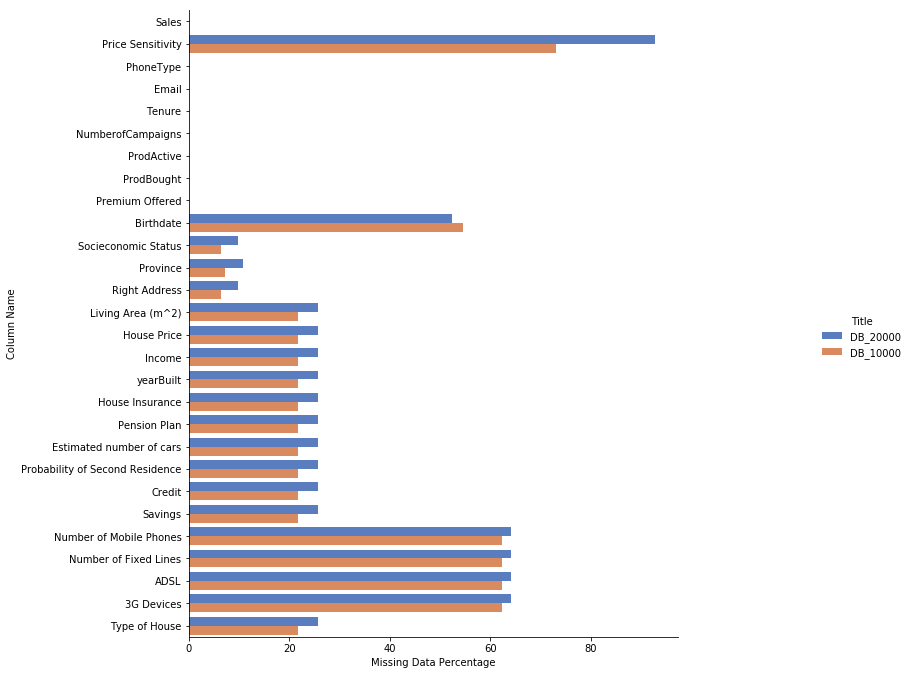

In [14]:
db_20k_fs_MD['Title'] = 'DB_20000'
db_10k_MD['Title'] = 'DB_10000'
db_aux_MV = pd.concat([db_20k_fs_MD[['Column Name','Title','Missing Data Percentage']],
                       db_10k_MD[['Column Name','Title','Missing Data Percentage']]])

g = sns.catplot(y='Column Name', x='Missing Data Percentage', hue='Title', data=db_aux_MV,
                height=6, kind="bar", orient="h",palette="muted")
fig = plt.gcf()
fig.set_size_inches(18, 10)

The custom function that produces the summarized information from the datasets also tags each feature as "categorical", "binary", "continuous"... according to some simple criteria, like the number of distinct values they contain. This information must be taken with a pinch of salt, since some specific cases lead to imprecise tags.  

For example, date features, such as "Tenure" or "Birthdate" may contain very few different values and get tagged as numerical categorical, and the same thing happens for count features such as "ProdActive" or "Number of Fixed Lines". These are actually ordinal features, where the few different values respect a meaningful order (and they should not be transformed into binary dummy ones).

The bottom line is that each feature must be individually studied and manipulated (given there is a reasonably small number of them).

In [15]:
db_20k_fs.describe()

,Sales,Price Sensitivity,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Premium Offered,Birthdate,Living Area (m^2),House Price,Income,yearBuilt,House Insurance,Pension Plan,Credit,Savings,Number of Mobile Phones,Number of Fixed Lines,ADSL,3G Devices
count,20000.000000,1475.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,9512.000000,14864.000000,1.486000e+04,1.486000e+04,14865.000000,14860.000000,1.486000e+04,1.486000e+04,1.484500e+04,7164.000000,7164.000000,7164.000000,7164.000000
mean,0.085750,3.792542,0.074450,2007.118950,3.709200,0.050700,0.320200,13.831877,1966.409062,196.099143,2.130899e+05,5.802174e+04,1979.502657,7364.270664,3.728715e+04,1.696786e+04,3.055875e+04,1.504467,1.005444,0.502233,0.503769
std,0.280002,1.694535,0.262508,6.715032,4.156429,0.238186,0.706397,2.774808,11.478364,566.227499,2.419406e+05,6.644060e+04,23.073381,8542.363258,4.239543e+04,1.945761e+04,7.872496e+04,1.120473,0.817475,0.500030,0.500021
min,0.000000,1.000000,0.000000,1990.000000,2.000000,0.000000,0.000000,11.120000,1944.000000,0.000000,9.784007e+03,2.190805e+03,1900.000000,186.013800,1.661723e+03,6.173887e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2004.000000,2.000000,0.000000,0.000000,11.120000,1957.000000,84.021240,1.237524e+05,3.348828e+04,1968.000000,4209.963300,2.163244e+04,9.783053e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.000000,0.000000,2010.000000,2.000000,0.000000,0.000000,14.500000,1967.000000,118.030440,1.702020e+05,4.624406e+04,1980.000000,5849.992800,2.977184e+04,1.351867e+04,0.000000e+00,2.000000,1.000000,1.000000,1.000000
75%,0.000000,5.000000,0.000000,2012.000000,4.000000,0.000000,0.000000,14.500000,1976.000000,176.119440,2.409671e+05,6.567726e+04,1999.000000,8348.550300,4.217209e+04,1.920983e+04,4.728410e+04,3.000000,2.000000,1.000000,1.000000
max,1.000000,6.000000,1.000000,2013.000000,32.000000,3.000000,6.000000,21.850000,1984.000000,33077.179640,1.495498e+07,4.106372e+06,2012.000000,527866.417800,2.620520e+06,1.202556e+06,4.884174e+06,3.000000,2.000000,1.000000,1.000000


In [16]:
db_10k.describe()

,Price Sensitivity,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Birthdate,Living Area (m^2),House Price,Income,yearBuilt,House Insurance,Pension Plan,Credit,Savings,Number of Mobile Phones,Number of Fixed Lines,ADSL,3G Devices
count,2694.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,4541.000000,7831.000000,7.830000e+03,7.831000e+03,7831.000000,7831.000000,7.831000e+03,7.831000e+03,7.831000e+03,3760.000000,3760.000000,3760.000000,3760.000000
mean,3.399777,0.046900,2011.248300,3.571400,0.022300,0.24210,1966.269764,203.416630,2.198855e+05,6.002617e+04,1978.753288,7648.644968,3.849267e+04,1.756162e+04,3.229642e+04,1.520479,0.992287,0.509309,0.499202
std,1.766382,0.211435,5.019897,4.237747,0.156221,0.64802,11.597210,597.405984,3.112247e+05,8.546163e+04,23.229961,10987.924223,5.453266e+04,2.502805e+04,8.328343e+04,1.116566,0.813359,0.499980,0.500066
min,1.000000,0.000000,1950.000000,2.000000,0.000000,0.00000,1944.000000,0.000000,7.057584e+03,1.580315e+03,1900.000000,134.177400,1.198663e+03,4.453454e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2012.000000,2.000000,0.000000,0.00000,1957.000000,82.289400,1.222000e+05,3.320332e+04,1967.000000,4199.999400,2.137713e+04,9.706360e+03,0.000000e+00,1.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,2012.000000,2.000000,0.000000,0.00000,1967.000000,115.293600,1.696126e+05,4.622528e+04,1979.000000,5874.251400,2.968637e+04,1.351993e+04,0.000000e+00,2.000000,1.000000,1.000000,0.000000
75%,5.000000,0.000000,2013.000000,4.000000,0.000000,0.00000,1976.000000,169.764600,2.427893e+05,6.631527e+04,1998.000000,8457.242400,4.250572e+04,1.940343e+04,4.751531e+04,3.000000,2.000000,1.000000,1.000000
max,6.000000,1.000000,2013.000000,34.000000,2.000000,5.00000,1984.000000,22943.212000,1.611964e+07,4.426344e+06,2012.000000,569032.313400,2.824619e+06,1.296269e+06,2.998083e+06,3.000000,2.000000,1.000000,1.000000


Concerning the numeric features (continuous, real-valued or discrete) there are apparently no anomalies in the summary statistics. We can notice some high maximum values for Living Area (in square meters), Houser Price and Income (assuming the currency is similar to € or US$), but they are not unrealistic for some specially wealthy individuals.  

If we look at them on a pairplot, we can easily spot these few "outliers", even though they are probably not errors in the data.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


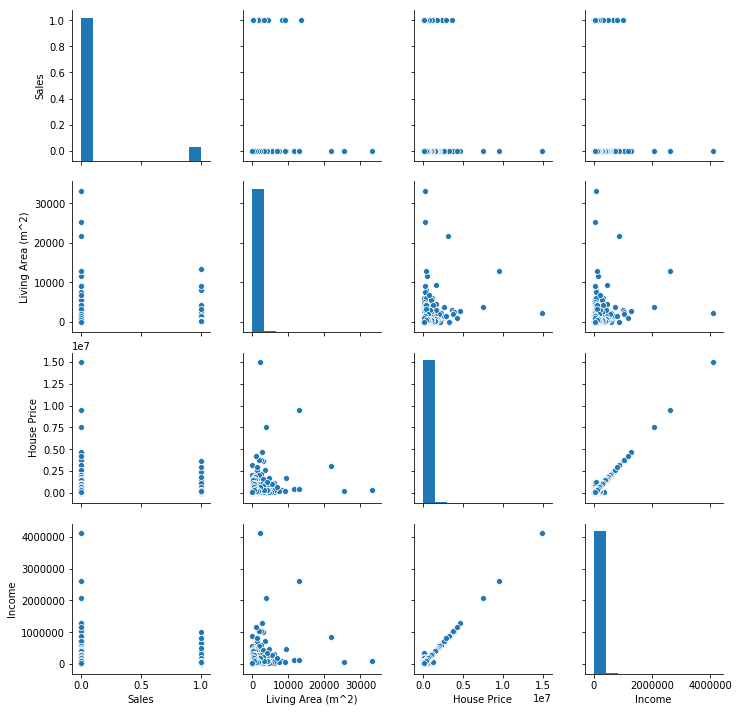

In [17]:
_ = sns.pairplot(db_20k_fs, vars=["Sales", "Living Area (m^2)", "House Price", "Income"])

This pairplot also shows a strong correlation between house price and income (later on we should take a look at the correlations between all the "socio-economic" features, since this behaviour is likely to show up again).

*I did not plot a pairplot for the complete dataset since it is hard to read with so many features, and it takes a lot of time to render in my current machine.

### 2.2 Initial Data Type Processing

From the analysis above, we know that there are some categorical/ordinal features that need to be associated to numeric values so that they can be fed to a machine learning algorithm.

In order to have a complete mapping of the categorical variables, it is important to consider all possible categories that might be present in a feature. For this reason, we will momentarily concatenate our two datesets in order to have exactly the same mapping in both of them.

In [18]:
df_all_data_aux = pd.concat([db_20k_fs.drop(['Sales','Premium Offered'],axis=1),db_10k]).reset_index()

#### Pure categorical features (not ordinal)

We will let pandas map them to numbers using its "category" type, since we are not really concerned about the order of the numbers.

In [19]:
cat_ft = ['PhoneType','Province','Right Address','Type of House']
for ft in cat_ft:
    df_all_data_aux[ft] = df_all_data_aux[ft].astype('category')
    print(ft)
    print(dict(enumerate(df_all_data_aux[ft].cat.categories)))
    df_all_data_aux[ft + '_cat'] = df_all_data_aux[ft].cat.codes
    df_all_data_aux[ft + '_cat'] = df_all_data_aux[ft + '_cat'].replace(-1,np.nan)

PhoneType
{0: 'FIXED / LAND PHONE', 1: 'MOBILE PHONE'}
Province
{0: 'A ', 1: 'AL', 2: 'AS', 3: 'AV', 4: 'BA', 5: 'BU', 6: 'CA', 7: 'CI', 8: 'CO', 9: 'CU', 10: 'GI', 11: 'GR', 12: 'GU', 13: 'HU', 14: 'JA', 15: 'LA', 16: 'LE', 17: 'LL', 18: 'LU', 19: 'MA', 20: 'ME', 21: 'MU', 22: 'OU', 23: 'PA', 24: 'PO', 25: 'SA', 26: 'SE', 27: 'SO', 28: 'TA', 29: 'TE', 30: 'TO', 31: 'VA', 32: 'VI', 33: 'ZA'}
Right Address
{0: 'Right', 1: 'Wrong'}
Type of House
{0: 'Rustic', 1: 'Urban'}


#### Ordinal features

In this case it is better to explicitly assign the ordered numbers to the classes so we make sure they respect their relative importance.

In [20]:
df_all_data_aux['Socieconomic Status_cat'] = df_all_data_aux['Socieconomic Status'].map({'Low':0,'Medium':1,'High':2,'Very High':3})
print('Socieconomic Status')
print(df_all_data_aux['Socieconomic Status'].unique())
print(df_all_data_aux['Socieconomic Status_cat'].unique())

Socieconomic Status
['Medium' nan 'Low' 'High' 'Very High']
[ 1. nan  0.  2.  3.]


In [21]:
df_all_data_aux['Estim. num. cars_cat'] = df_all_data_aux['Estimated number of cars'].map({'None':0,'One':1,'two':2,'Three':3})
print('Estimated number of cars')
print(df_all_data_aux['Estimated number of cars'].unique())
print(df_all_data_aux['Estim. num. cars_cat'].unique())

Estimated number of cars
['two' 'None' 'One' nan 'Three']
[ 2.  0.  1. nan  3.]


In [22]:
df_all_data_aux['Proba. Sec. Res._cat'] = df_all_data_aux['Probability of Second Residence'].map({'Low':0,'Medium':1,'High':2})
print('Probability of Second Residence')
print(df_all_data_aux['Probability of Second Residence'].unique())
print(df_all_data_aux['Proba. Sec. Res._cat'].unique())

Probability of Second Residence
['Low' nan 'High' 'Medium']
[ 0. nan  2.  1.]


#### Original datasets recovery

Once the categorical features transformations are dealt with, we get our original datasets back.

In [23]:
db_20k_fs = df_all_data_aux.iloc[:20000,:].join(db_20k_fs[['Sales','Premium Offered']]).set_index('index')
db_20k_fs.head(2)

,Price Sensitivity,PhoneType,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Birthdate,Socieconomic Status,Province,Right Address,Living Area (m^2),House Price,Income,yearBuilt,House Insurance,Pension Plan,Estimated number of cars,Probability of Second Residence,Credit,Savings,Number of Mobile Phones,Number of Fixed Lines,ADSL,3G Devices,Type of House,PhoneType_cat,Province_cat,Right Address_cat,Type of House_cat,Socieconomic Status_cat,Estim. num. cars_cat,Proba. Sec. Res._cat,Sales,Premium Offered
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,FIXED / LAND PHONE,0,2012,2,0,0,NaN,Medium,MA,Right,68.28964,439134.274215,55407.736314,2005.0,15345.3798,76897.09528,two,Low,35147.05566,0.0,NaN,NaN,NaN,NaN,Urban,0,19.0,0.0,1.0,1.0,2.0,0.0,0,11.12
1,NaN,MOBILE PHONE,0,2011,2,0,1,1961.0,Medium,CA,Right,85.60244,103235.979015,27854.157114,1998.0,3485.5758,18037.38088,None,Low,8133.08226,0.0,NaN,NaN,NaN,NaN,Rustic,1,6.0,0.0,0.0,1.0,0.0,0.0,1,11.12


In [24]:
df_10k = df_all_data_aux.iloc[20000:,:].set_index('index')
df_10k.head(2)

,Price Sensitivity,PhoneType,Email,Tenure,NumberofCampaigns,ProdActive,ProdBought,Birthdate,Socieconomic Status,Province,Right Address,Living Area (m^2),House Price,Income,yearBuilt,House Insurance,Pension Plan,Estimated number of cars,Probability of Second Residence,Credit,Savings,Number of Mobile Phones,Number of Fixed Lines,ADSL,3G Devices,Type of House,PhoneType_cat,Province_cat,Right Address_cat,Type of House_cat,Socieconomic Status_cat,Estim. num. cars_cat,Proba. Sec. Res._cat
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6.0,FIXED / LAND PHONE,0,2011,4,0,0,1962.0,High,OU,Right,60.4474,230139.624195,62842.06971,1961.0,8010.6894,40289.464296,One,Low,18386.272962,56033.07732,2.0,1.0,1.0,0.0,Urban,0,22.0,0.0,1.0,2.0,1.0,0.0
1,NaN,FIXED / LAND PHONE,0,2012,2,0,0,NaN,Medium,VA,Right,78.0148,119859.179895,21367.73331,1955.0,2678.2794,13824.893096,None,Low,6240.219762,0.00000,NaN,NaN,NaN,NaN,Urban,0,31.0,0.0,1.0,1.0,0.0,0.0


We finally save these modified datasets to disk so we can load them in a different notebook (for EDA or modelling)

In [25]:
with open(proc_data_PATH + 'dataframes.pkl', 'wb') as f:
    pickle.dump([db_20k_fs,df_10k], f)

***

## 3. Missing Data Analysis

We will now take a closer look at the missing values and decide which strategies we will use for dealing with them, be it deletion or imputation.

### 3.1 Train/Test Split

Since the data at hand will be used for training a machine learning model, it is important to hold out a part of the data for its validation before we start manipulating it.

This includes the imputation of missing values, which must be based only on the training data.

In [26]:
db_20k_train, db_20k_test = train_test_split(db_20k_fs, test_size=0.2, random_state=17, stratify = db_20k_fs.Sales)

In [27]:
db_20k_fs_MD = df_custom_info(db_20k_fs)

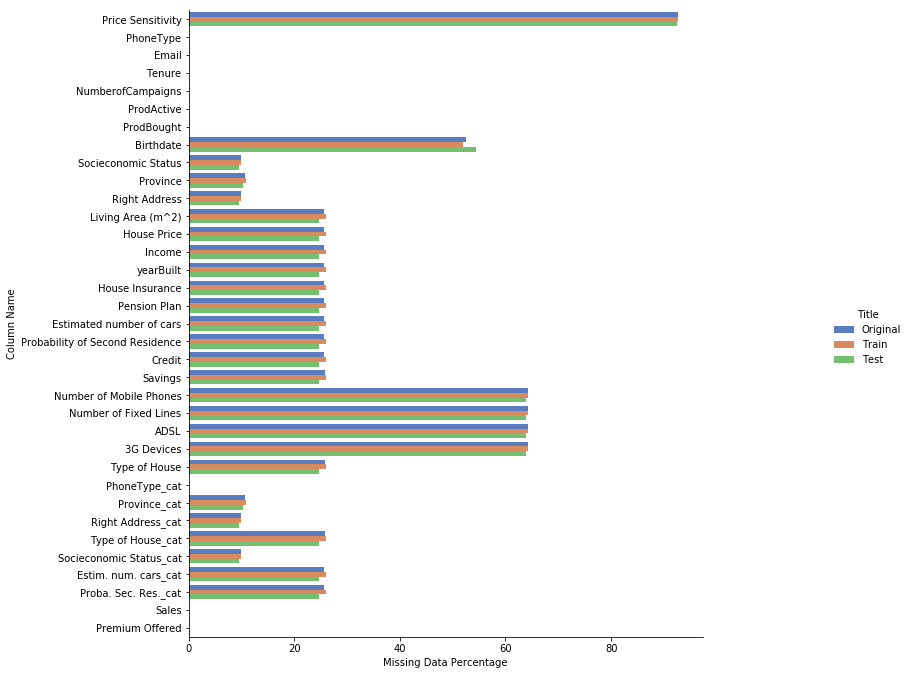

In [28]:
db_20k_fs_MD['Title'] = 'Original'
db_20k_train_MD = df_custom_info(db_20k_train)
db_20k_train_MD['Title'] = 'Train'
db_20k_test_MD = df_custom_info(db_20k_test)
db_20k_test_MD['Title'] = 'Test'
db_aux_MV = pd.concat([db_20k_fs_MD[['Column Name','Title','Missing Data Percentage']],
                       db_20k_train_MD[['Column Name','Title','Missing Data Percentage']],
                       db_20k_test_MD[['Column Name','Title','Missing Data Percentage']]])

g = sns.catplot(y='Column Name', x='Missing Data Percentage', hue='Title', data=db_aux_MV,
                height=6, kind="bar", orient="h", palette="muted")
fig = plt.gcf()
fig.set_size_inches(18, 10)

We observe that the proportion of missing values for all features is the same in both train and test sets, and also equal to this proportion in the original dataset.

In [29]:
print('Total number of rows in train dataset: ', db_20k_train.shape[0])
print('Number of rows in train dataset with no missing values: ', db_20k_train.dropna().shape[0])
print('Percentage of instances with all features available: %2.2f'%
     ((db_20k_train.dropna().shape[0]/db_20k_train.shape[0])*100))

Total number of rows in train dataset:  16000
Number of rows in train dataset with no missing values:  206
Percentage of instances with all features available: 1.29


A common way to decide if a feature must be dropped or kept (for later imputation) is to see if it is highly correlated or not to the target variable.  

The problem is that the usual methods for computing the pair-wise correlation matrix (such as .corr() from Pandas) ignore missing values. In our case, the available amount of instances where all features are complete is tiny compared to the whole dataset, which may not be enough to shed light on the actual relationships between the features.  

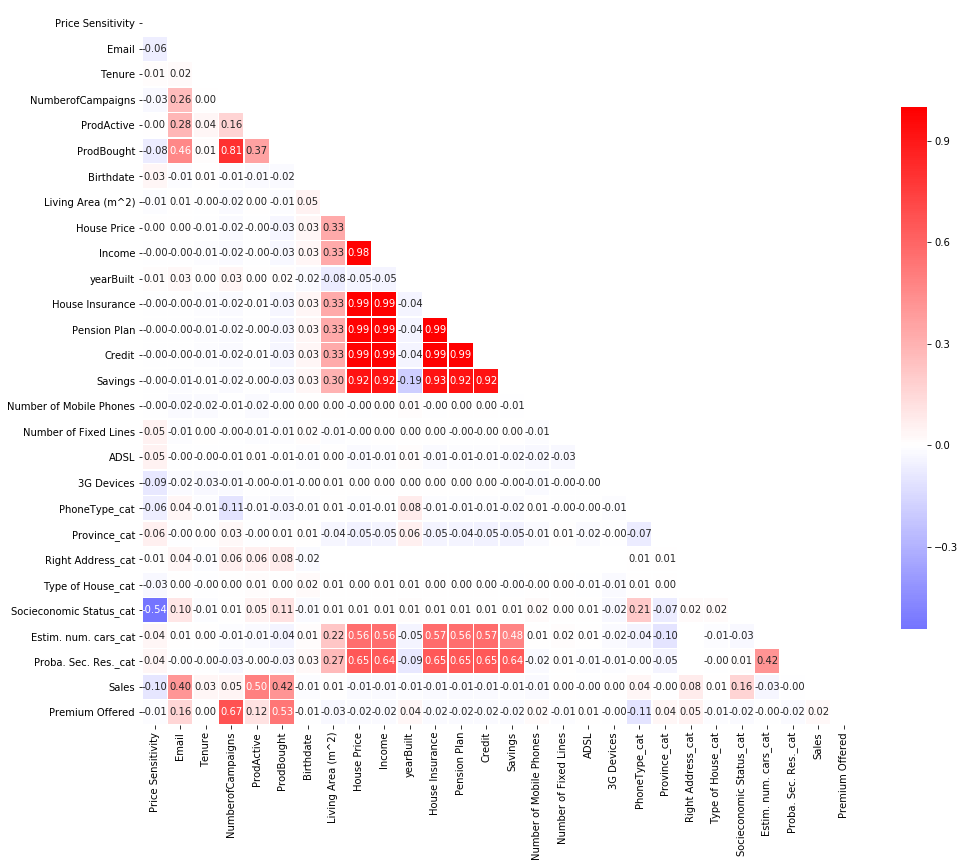

In [30]:
plot_corr_heatmap(db_20k_train.corr())

If we look at the full correlation matrix (represented on a heatmap), without considering any missing values, we can see some noticeable correlations between the target variable and some of the features (like 'Price Sensitivity', 'Email', 'ProdActive', 'ProdBought' or 'Socioeconmic Status').

We will delve into the logic behind this relationships later, at the "Exploratory Data Analysis" section.

We can also notice strong correlations between some of the features: the economic ones, such as savings, income, house-related data... are strongly and positively correlated, which makes perfect sense.

There is also a strong negative correlation between 'Price Sensitivity' and 'Socioeconomic Status', which may provide a proper way to impute the former, where most of the data is missing.

Now let's plot the same heatmap imposing a value of -9999 for al missing data (-9999 is out of the range of any of the existing continuous features and is different from any of the numeric values used for representing categories, so it can effectively represent "absence of data" without biasing the existing data too much)

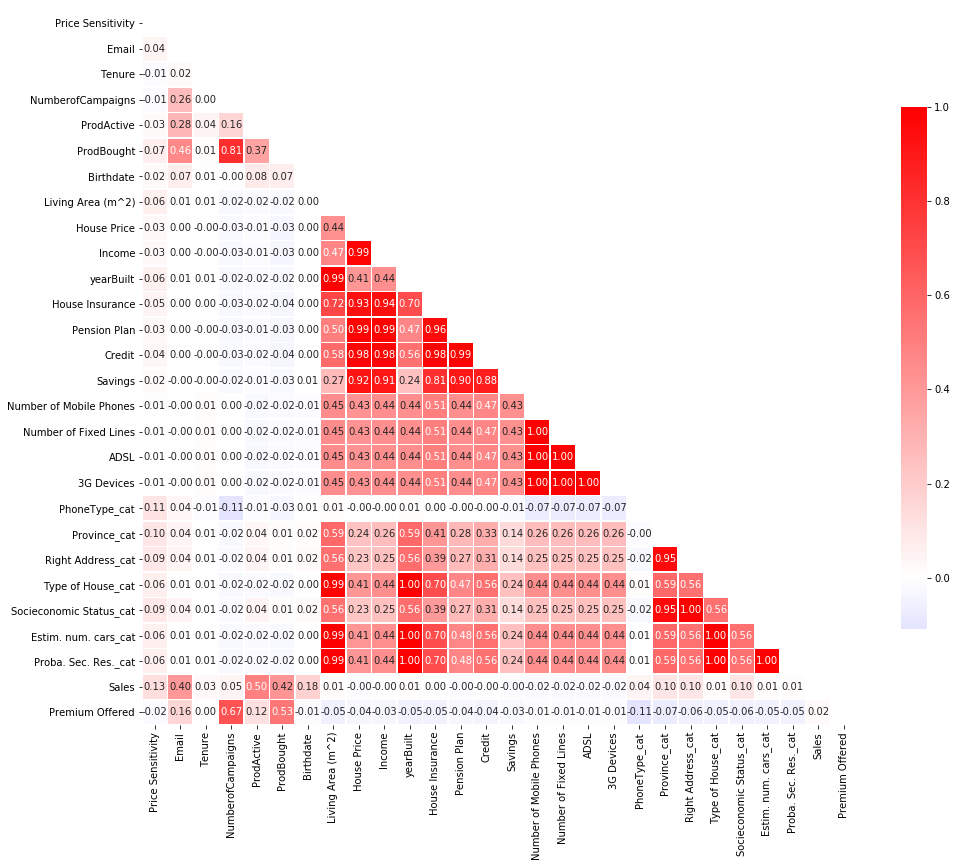

In [31]:
plot_corr_heatmap(db_20k_train.drop(['PhoneType','Province','Right Address',
                                     'Type of House','Socieconomic Status',
                                     'Estimated number of cars','Probability of Second Residence'],axis=1).fillna(-9999).corr())

With this crude value replacement, many of the correlations between features increase greatly.

This means the aforesaid features are missing at the same time for many samples. The reason behind this may have something to do with the data gathering process, where many people were not asked for this information, or they decided not to provide any of it.

This situation can hinder some imputation strategies such as those based on linear regression.

***

In [32]:
# Dictionary where the imputation strategy (or deletion) for each feature will be stored
MV_imputation = {}

In order to make the missing data analysis more manageable, we will break it down in three parts:
- Features with more than 50% missing data, which might be directly dropped.
- Economic features, which are strongly correlated between themselves
- Rest of features

### 3.2 Features with more than 50% missing data

We will calculate the correlation matrix for features with more than 50% of missing data using the available data only, and then replacing the NaNs with an additional value (say -9999 for numeric variables that are strictly positive) in order to represent a "missing category".

In [33]:
cols_more_than_50_MV = db_20k_train_MD[db_20k_train_MD['Missing Data Percentage'] > 50]['Column Name'].tolist()
print(cols_more_than_50_MV)

['Price Sensitivity', 'Birthdate', 'Number of Mobile Phones', 'Number of Fixed Lines', 'ADSL', '3G Devices']


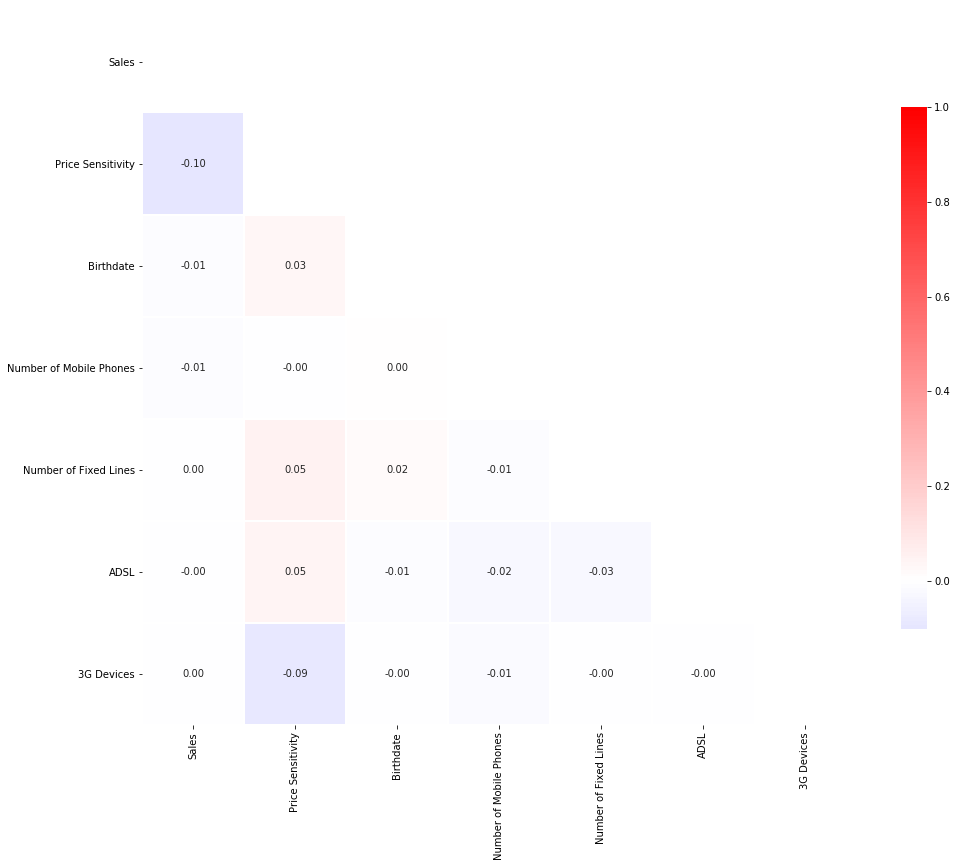

In [34]:
plot_corr_heatmap(db_20k_train[['Sales']+cols_more_than_50_MV].corr())

We see that there is almost no correlation between our target variable and any of the selected variables (and almost no correlation between any pair of them) if we consider non missing data only.

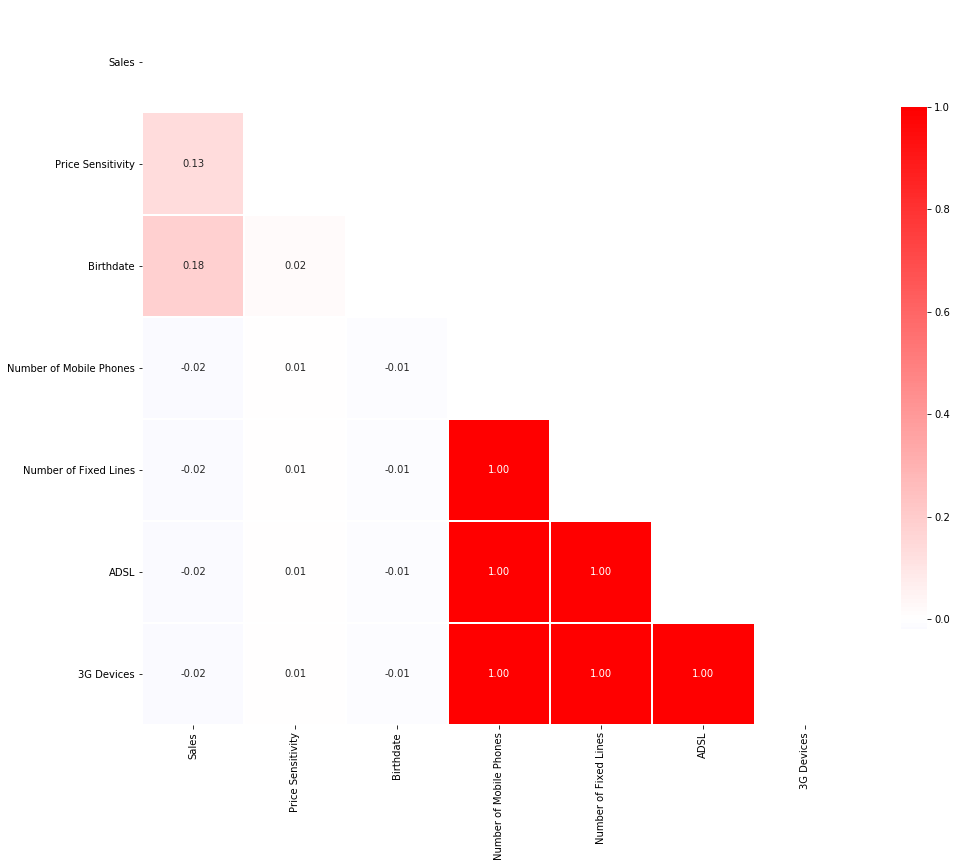

In [35]:
plot_corr_heatmap(db_20k_train[['Sales']+cols_more_than_50_MV].fillna(-9999).corr())

After we simulate the absence of data with a numeric value we can see that there are actually 4 out of these 6 features that are still very weakly correlated to the target value (these are 'Number of Mobile Phones', 'Number of Fixed Lines', 'ADSL' and '3G Devices'). They will be dropped.

As for 'Price Sensitivity' and 'Birthdate', they have a certain correlation with 'Sales', so their possible imputation will be studied.

'Price Sensitivity' presents a hard case: It lacks a great proportion of instances but it intuitively sounds like a variable that might influence the probability of sale.

In [36]:
# We drop the aforesaid features to make data more manageable during the rest of this analysis, even though
# the complete deletion/imputation process will take place in a different notebook
db_20k_train = db_20k_train.drop(['Number of Mobile Phones', 'Number of Fixed Lines', 'ADSL', '3G Devices'],axis=1)

In [37]:
for ft in ['Number of Mobile Phones', 'Number of Fixed Lines', 'ADSL', '3G Devices']:
    MV_imputation[ft] = 'drop'

#### Birthdate

This variable is not strongly correlated to any other feature or to the target variable, and more than half of it is missing.

Age is normally an interesting demographic factor for customer behaviour analysis, and it feels counterintuitive to drop it. However, in our particular case, it would be difficult to impute it in an informed way, given the weak relationship it has to the rest of the features.

In [38]:
MV_imputation['Birthdate'] = 'drop'

#### Price Sensitivity

This variable is moderately correlated to the target variable and fairly correlated to Socieconomic Status, which has not too many missing values.

This one presents a very delicate case:
- It has a really large amount of missing values, which points at dropping it out entirely.
- The feature it is correlated to (Socieconomic Status) is also discrete and has less distinct values, which could make a regression impossible.
- On the other hand, there is some correlation between it and our target variable, and the Price Sensitivity of an individual does sound like something important to consider when deciding if he is likely to buy and for what price.

So we will decide how to impute Socieconomic Status and the rest of features first, and then come back to Price Sensitivity to see if something reasonble can be done to keep it.

In [39]:
print('Socieconomic Status distinct values: ', db_20k_train['Socieconomic Status_cat'].unique())
print('Price Sensitivity distinct values: ', db_20k_train['Price Sensitivity'].unique())

Socieconomic Status distinct values:  [ 1.  0.  2. nan  3.]
Price Sensitivity distinct values:  [nan  4.  1.  2.  3.  5.  6.]


### 3.3 Economic features

Socieconomic Status is fairly correlated to the target variable and also to some features like PhoneType or ProdBought (which have no missing values).

Since the aforementioned correlations are not specially high (0.21 with respect to PhoneType is the highest), a simple imputation method will be used for this variable. A regression with respect to economy related features would have been more desirable, but with the available data we do not see a strong correlation to them (see zoomed in heatmap below).

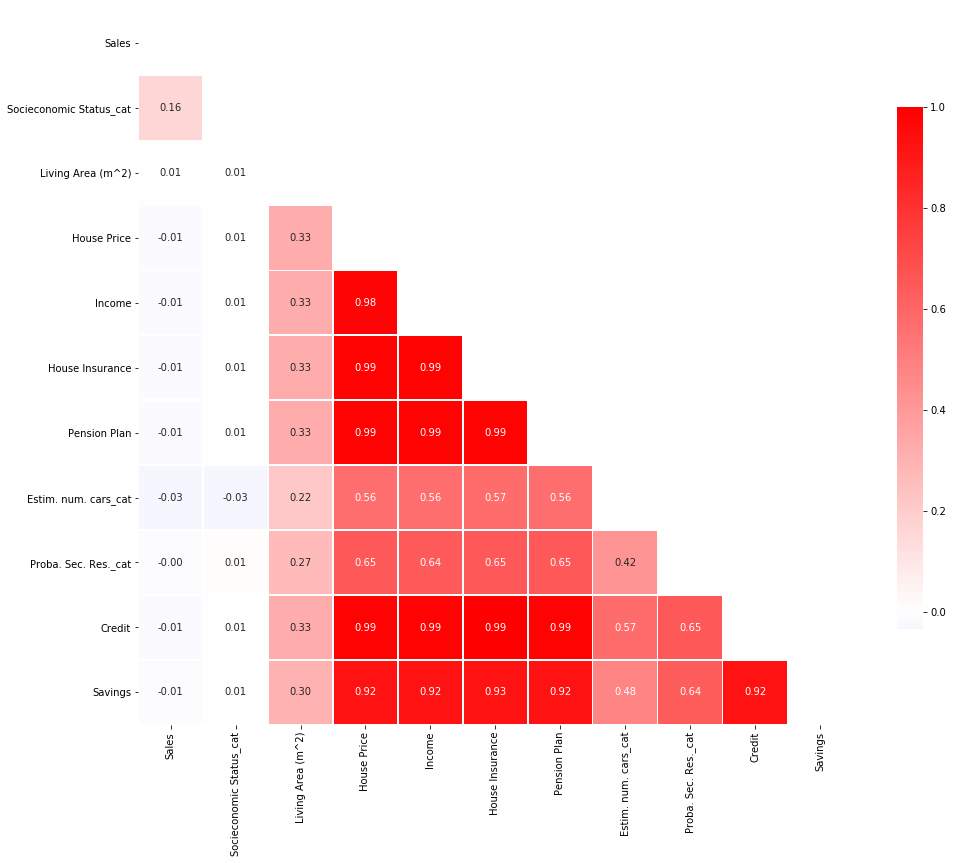

In [40]:
economic_ft = ['Socieconomic Status_cat','Living Area (m^2)','House Price',
               'Income','House Insurance','Pension Plan','Estim. num. cars_cat',
               'Proba. Sec. Res._cat','Credit','Savings']
plot_corr_heatmap(db_20k_train[['Sales']+economic_ft].corr())

The rest of economic features present very low correlation values with respect to the target variable.

They are, on the other hand, strongly correlated between themselves, but this is not specially useful from an imputation point of view, since most of the times, when one of them is missing for a given sample, the rest are missing too (and vice versa).

#### Socieconomic Status

We will take the most frequent value ('Medium') for the imputation of this feature as a conservative option.

In [41]:
print(db_20k_train['Socieconomic Status'].value_counts())

Medium       8732
Low          4296
High          694
Very High     679
Name: Socieconomic Status, dtype: int64


In [42]:
MV_imputation['Socieconomic Status_cat'] = ('mode')

#### Rest of economic features

For the rest, we will take the median value to get an intermediate value that is not affected by the extreme cases representing very wealthy people, which are not frequent.

In [43]:
for ft in economic_ft[1:]:
    MV_imputation[ft] = ('median')

### 3.4 Other features

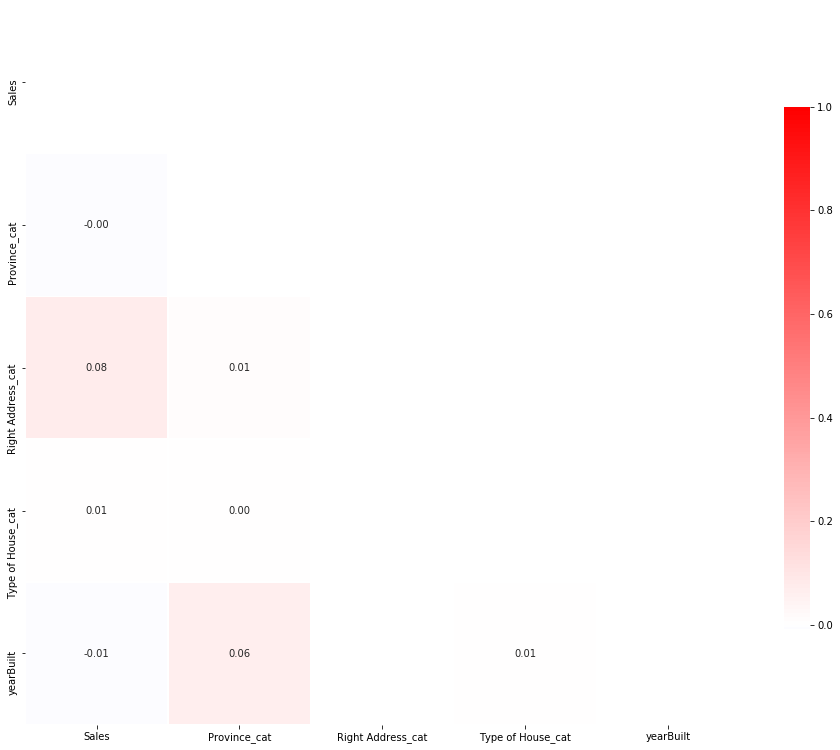

In [44]:
other_ft = ['Province_cat','Right Address_cat','Type of House_cat','yearBuilt']
plot_corr_heatmap(db_20k_train[['Sales']+other_ft].corr())

We see there is almost no correlation between any of these features and the target variable, or between themselves.  
There are actually cases where the correlation is not calculated, probably due to the fact that there are not individual samples where both features contain a value.

We will use the mode for Province, Type of House and Right address (categorical) and the median for yearBuilt (continuous).

In [45]:
for ft in other_ft[:-1]:
    MV_imputation[ft] = ('mode')

In [46]:
MV_imputation['yearBuilt'] = ('median')

#### Price Sensitivity (bis)

Now we have decided to keep Socieconomic Status and how to impute, let's see if we can use it for filling the missing values of Price Sensitivity.

Let's plot the count of missing values of this feature that correspond to negative and positivet values of our target variable.

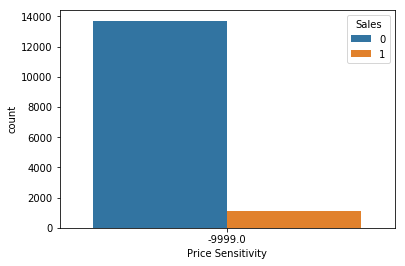

In [47]:
db_20k_train_aux = db_20k_train.copy()
db_20k_train_aux['Price Sensitivity'] = db_20k_train_aux['Price Sensitivity'].fillna(-9999)
_ = sns.countplot(x='Price Sensitivity',hue='Sales',data=db_20k_train_aux[db_20k_train_aux['Price Sensitivity'] == -9999])

We can see that most missing values of Price Sensitivity correspond to a negative sale case. This means that if we imputed it with a constant value (say the mean or the median) we might introduce an important amount of bias in the sense that predictive models trained on these data might associate such value to a low probability of sale in a very strong way (which might not be correct).

Now we will look at how the existing values of Price Sensitivity are related to Socieconomic Status.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


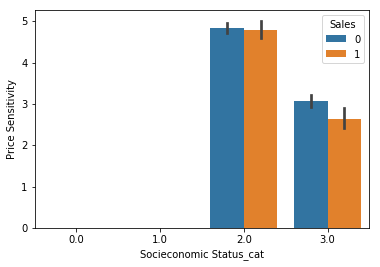

In [48]:
_ = sns.barplot(y ='Price Sensitivity', x='Socieconomic Status_cat',hue='Sales',data=db_20k_train)

The plot above shows an interesting fact: for those samples which contain non-null information of Price Sensitivity and Socieconomic Status, the latter is always 2 or 3. Moreover, when it is 2, Price Sensitivity has an average value of 5, and when it is 3, it has an average value of 3 (in both cases with balanced proportions of negative and positive sales).

This allows for devising an informed imputation strategy that is more sophisticated and probably more accurate than just filling all missing vaues with a constant.

We will impute Price Sensitivity with a value of 3 whenever Socieconomic Status is also 3, and with a value of 5 whenever Socieconomic Status is 2 (or less, in case in new training set we find such case for missing values)

In [49]:
MV_imputation['Price Sensitivity'] = ('custom')

In [50]:
# We finally save the dictionary with the missing data strategies to disk for later use
with open(proc_data_PATH + 'MV_imputation_dict.pkl', 'wb') as f:
    pickle.dump(MV_imputation, f)